## GPU Setting

In [38]:
import torch

# 檢查 M4 Pro (Apple Silicon) 的 MPS 加速
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available(): # 保留 CUDA 選項以便未來相容
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


# Config

In [39]:
config = {
    'dataset':{
        'train_ratio': 0.8,
        'sampling_rate': 256,
        'data_type': 'raw',
        'balance': False,
        'ictal_def': [15, 60]
    },
    'params':{
        'batch_size': 32,
        'class_weight': 0.9/0.1,
        'epoch': 80,
        'lr': 3e-4,
        'weight_decay': 1e-6,
        'alpha': 0.7,
        'gamma': 2,
        'threshold': 0.5
    },
    'eval':{
        'metrics': 'all',
        'save_metric': 'F1_score'
    }
}

# **INPUT DATA**

## Import Tools

In [40]:
from torch import nn
from torch.utils.data import DataLoader, random_split
import mne
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('main')
pl.seed_everything(42, workers=True)

Seed set to 42


42

## Preprocessing & Dataloader

Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2962557342.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


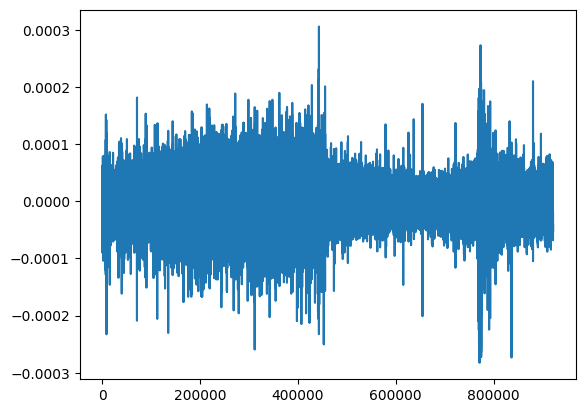

In [41]:
obj = "chb01_03"

file = f"CHB_EEG/{obj}.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
plt.plot(raw_data[1])

print(raw_data.shape)

In [42]:
# open json
with open(f"CHB_EEG/seizure_time_{config['dataset']['ictal_def'][0]}_{config['dataset']['ictal_def'][1]}.json", 'r') as f:
  seizure_time = json.load(f)
items = list(seizure_time.items())

# devide datasets
train_eeg_signal = []
for (obj, info) in items[3:21]:
  file = f"CHB_EEG/{obj}.edf"
  data = mne.io.read_raw_edf(file)
  raw_data = data.get_data()
  print(raw_data.shape)
  train_eeg_signal.append(raw_data)
train_timepoints = items[3:21]

val_eeg_signal = []
for (obj, info) in items[:3]:
  file = f"CHB_EEG/{obj}.edf"
  data = mne.io.read_raw_edf(file)
  raw_data = data.get_data()
  print(raw_data.shape)
  val_eeg_signal.append(raw_data)
val_timepoints = items[:3]

test_eeg_signal = []
for (obj, info) in items[21:]:
  file = f"CHB_EEG/{obj}.edf"
  data = mne.io.read_raw_edf(file)
  raw_data = data.get_data()
  print(raw_data.shape)
  test_eeg_signal.append(raw_data)
test_timepoints = items[21:]

Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 681728)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF parameters from /Users/kimi/Documents/GitHub/seizure_pred/CHB_EEG/chb01_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)
Extracting EDF paramet

/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipykernel_2229/2073300456.py:28: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)
/var/folders/f8/c8zc8mm172s87fft_kc_0lt40000gn/T/ipy

In [43]:
from dataset import MFCCDataset, RawDataset

if config['dataset']['data_type'] == 'MFCC':
  dataset = MFCCDataset(eeg_signal, ontime)

  train_size = int(config['dataset']['train_ratio'] * len(dataset))
  val_size   = len(dataset) - train_size

  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print(len(train_dataset), len(val_dataset))

  # test dataset
  eeg_signal = []
  ontime = []
  for (obj, info) in items[:1]:
    file = f"CHB_EEG/{obj}.edf"
    data = mne.io.read_raw_edf(file)
    raw_data = data.get_data()
    print(raw_data.shape)
    eeg_signal.append(raw_data)
    ontime.append(info['seizure_start_time'])
  test_dataset = MFCCDataset(eeg_signal, ontime)
  print(len(test_dataset))
  print(ontime)

elif config['dataset']['data_type'] == 'raw':
  train_dataset = RawDataset(train_eeg_signal, train_timepoints, mode='train', balance=config['dataset']['balance'])
  val_dataset = RawDataset(val_eeg_signal, val_timepoints, mode='val')
  test_dataset = RawDataset(test_eeg_signal, test_timepoints, mode='test')

print("Before downsampling:")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Before downsampling:
Train: 7800, Val: 1500, Test: 2630


In [44]:
# Downsample negative samples to balance the dataset (1:1 ratio)
def downsample_negative_samples(dataset, random_seed=42):
    """
    Downsample negative samples to match the number of positive samples.
    Returns a new dataset with balanced classes.
    """
    np.random.seed(random_seed)

    # Get all labels
    labels = np.array([dataset[i][1] for i in range(len(dataset))])

    # Find indices of positive and negative samples
    pos_indices = np.where(labels == 1)[0]
    neg_indices = np.where(labels == 0)[0]

    print(f"Original - Positive: {len(pos_indices)}, Negative: {len(neg_indices)}, Ratio: {len(neg_indices)/len(pos_indices):.2f}:1")

    # If no positive samples, return original dataset
    if len(pos_indices) == 0:
        print("Warning: No positive samples found, returning original dataset")
        return dataset

    # Randomly sample negative indices to match positive count
    if len(neg_indices) > len(pos_indices):
        sampled_neg_indices = np.random.choice(neg_indices, size=len(pos_indices), replace=False)
    else:
        sampled_neg_indices = neg_indices

    # Combine positive and sampled negative indices
    balanced_indices = np.concatenate([pos_indices, sampled_neg_indices])
    np.random.shuffle(balanced_indices)  # Shuffle to mix classes

    # Create new balanced dataset
    balanced_data = [dataset.data[i] for i in balanced_indices]
    balanced_labels = [dataset.label[i] for i in balanced_indices]

    # Create a simple dataset-like object or update existing dataset
    class BalancedDataset:
        def __init__(self, data, labels):
            self.data = data
            self.label = labels

        def __len__(self):
            return len(self.label)

        def __getitem__(self, idx):
            return self.data[idx], self.label[idx]

    balanced_dataset = BalancedDataset(balanced_data, balanced_labels)

    # Verify balance
    balanced_labels_check = np.array([balanced_dataset[i][1] for i in range(len(balanced_dataset))])
    pos_count = np.sum(balanced_labels_check == 1)
    neg_count = np.sum(balanced_labels_check == 0)
    print(f"Balanced - Positive: {pos_count}, Negative: {neg_count}, Ratio: {neg_count/pos_count:.2f}:1")

    return balanced_dataset

# Apply downsampling to training dataset only (keep val/test original for realistic evaluation)
print("\nDownsampling training dataset...")
train_dataset = downsample_negative_samples(train_dataset, random_seed=42)

print(f"\nAfter downsampling:")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Downsampling training dataset...
Original - Positive: 851, Negative: 6949, Ratio: 8.17:1
Balanced - Positive: 851, Negative: 851, Ratio: 1.00:1

After downsampling:
Train: 1702, Val: 1500, Test: 2630


In [45]:
def normalize_per_sample(data_list):
    """Normalize each sample independently to avoid distribution shift"""
    normalized = []
    for sample in data_list:
        sample_flat = sample.flatten()
        mean = np.mean(sample_flat)
        std = np.std(sample_flat)
        if std > 1e-8:  # avoid division by zero
            normalized.append((sample - mean) / std)
        else:
            normalized.append(sample)
    return normalized

print("Normalizing data per-sample (each window independently)...")
train_dataset.data = normalize_per_sample(train_dataset.data)
val_dataset.data = normalize_per_sample(val_dataset.data)
test_dataset.data = normalize_per_sample(test_dataset.data)
print("Normalization complete")

Normalizing data per-sample (each window independently)...
Normalization complete


In [46]:
'''
X_train = np.array(train_dataset.data)
X_val   = np.array(val_dataset.data)
X_test  = np.array(test_dataset.data)

X_train = X_train.reshape(X_train.shape[0], -1)
X_val   = X_val.reshape(X_val.shape[0], -1)
X_test  = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

train_dataset.data = X_train
val_dataset.data   = X_val
test_dataset.data  = X_test
'''

'\nX_train = np.array(train_dataset.data)\nX_val   = np.array(val_dataset.data)\nX_test  = np.array(test_dataset.data)\n\nX_train = X_train.reshape(X_train.shape[0], -1)\nX_val   = X_val.reshape(X_val.shape[0], -1)\nX_test  = X_test.reshape(X_test.shape[0], -1)\n\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_val   = scaler.transform(X_val)\nX_test  = scaler.transform(X_test)\n\ntrain_dataset.data = X_train\nval_dataset.data   = X_val\ntest_dataset.data  = X_test\n'

In [47]:
# count positive and negative samples
labels = [train_dataset[i][1] for i in range(len(train_dataset))]
label_counts = Counter(labels)
label_counts = Counter({int(k): v for k, v in label_counts.items()})
total = sum(label_counts.values())
label_ratio = {int(k): v / total for k, v in label_counts.items()}


print(f'train dataset: {label_counts, label_ratio}')
labels = [val_dataset[i][1] for i in range(len(val_dataset))]
label_counts = Counter(labels)
label_counts = Counter({int(k): v for k, v in label_counts.items()})
total = sum(label_counts.values())
label_ratio = {int(k): v / total for k, v in label_counts.items()}


print(f'val dataset: {label_counts, label_ratio}')
labels = [test_dataset[i][1] for i in range(len(test_dataset))]
label_counts = Counter(labels)
label_counts = Counter({int(k): v for k, v in label_counts.items()})
total = sum(label_counts.values())
label_ratio = {int(k): v / total for k, v in label_counts.items()}

print(f'test dataset: {label_counts, label_ratio}')

train dataset: (Counter({1: 851, 0: 851}), {1: 0.5, 0: 0.5})
val dataset: (Counter({0: 1320, 1: 180}), {0: 0.88, 1: 0.12})
test dataset: (Counter({0: 2450, 1: 180}), {0: 0.9315589353612167, 1: 0.06844106463878327})


In [48]:
train_loader = DataLoader(train_dataset, batch_size=config['params']['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['params']['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['params']['batch_size'], shuffle=False)

In [49]:
# Create weighted sampler to handle class imbalance (1:9 ratio)
from torch.utils.data import WeightedRandomSampler

# Calculate class weights for sampling
train_labels = np.array([train_dataset[i][1] for i in range(len(train_dataset))])
class_counts = np.bincount(train_labels.astype(int))
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_labels.astype(int)]
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Use sampler for train (balances batches), no sampler for val/test
train_loader = DataLoader(
    train_dataset,
    batch_size=config['params']['batch_size'],
    sampler=weighted_sampler
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config['params']['batch_size'],
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config['params']['batch_size'],
    shuffle=False
)

In [50]:
next(iter(train_loader))[0].shape

torch.Size([32, 23, 1280])

# **MODEL**

## MLP

In [51]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(32, 16),
            nn.Sigmoid(),
            nn.Dropout(p=0.3)
        )
        self.fc5 = nn.Sequential(
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x

## CNN

In [52]:
class CNN_MLP(nn.Module):
    """
    CNN feature extractor followed by MLP classifier.
    Architecture:
    - 4 Conv2d layers (32 kernels each, kernel_size=3x2)
    - 3 MaxPool2d layers (pool_size=2x2)
    - BatchNorm + ReLU after each conv
    - MLP classifier (300->100->50->20->1)
    """
    def __init__(self, input_channels=23, input_time=1280, dropout_p=0.3):
        """
        Args:
            input_channels: Number of EEG channels (default 23)
            input_time: Time points per sample (5 sec * 256 Hz = 1280)
            dropout_p: Dropout probability (not used in CNN, kept for compatibility)
        """
        super(CNN_MLP, self).__init__()

        # CNN Feature Extractor
        # Input: (batch, 1, channels, time)
        # Conv1: 1 -> 32 kernels, kernel_size=(3, 2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 2), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Conv2: 32 -> 32 kernels, kernel_size=(3, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 2), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Conv3: 32 -> 32 kernels, kernel_size=(3, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 2), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Conv4: 32 -> 32 kernels, kernel_size=(3, 2) (no pooling after this)
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 2), stride=1, padding=(1, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        dummy_x = torch.zeros(1, input_channels, input_time)
        dummy_x = dummy_x.unsqueeze(0) if dummy_x.ndim == 3 else dummy_x  # (1, 23, 1280) -> (1, 23, 1280)
        x = self.conv1(dummy_x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        flatten_size = x.numel()
        self.mlp = nn.Sequential(
            nn.Linear(flatten_size, 300),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(50, 20),
            nn.Sigmoid(),
            nn.Dropout(0.3),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        # 1. 修正：將 (B, C, T) 轉為 (B, 1, C, T) 以符合 Conv2d 輸入
        # (B=batch_size, C=channels, T=time)
        x = x.unsqueeze(1)

        # CNN Feature Extraction
        # 4 conv layers + 3 maxpool layers
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)

        # Flatten for MLP
        x = x.view(x.size(0), -1)

        # 2. 修正：移除多餘的 if 區塊 (self.mlp 已在 __init__ 中定義)
        # if self.mlp is None:
        #     ...

        # MLP Classification
        x = self.mlp(x)
        return x

## EEGNet

In [53]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 120

        # Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, (1, 64), padding = 0),
            nn.ELU(),
            nn.BatchNorm2d(16, False),
            nn.Dropout(0.25)
        )

        # Layer 2
        self.layer2 = nn.Sequential(
            nn.ZeroPad2d((16, 17, 0, 1)),
            nn.Conv2d(1, 4, (2, 32)),
            nn.ELU(),
            nn.BatchNorm2d(4, False),
            nn.Dropout(0.25),
            nn.MaxPool2d(2, 4)
        )

        # Layer 3
        self.layer3 = nn.Sequential(
            nn.ZeroPad2d((2, 1, 4, 3)),
            nn.Conv2d(4, 4, (8, 4)),
            nn.ELU(),
            nn.BatchNorm2d(4, False),
            nn.Dropout(0.25),
            nn.MaxPool2d((2, 4))
        )

        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints.
        self.fc1 = nn.Linear(4*2*7, 1)


    def forward(self, x):
        # Layer 1
        x = self.layer1(x)
        x = x.permute(0, 3, 1, 2)

        # Layer 2
        x = self.layer2(x)

        # Layer 3
        x = self.layer3(x)

        # FC Layer
        x = x.view(-1, 4*2*7)
        x = nn.sigmoid(self.fc1(x))
        return x

# **Training Pipeline**

In [54]:
# Training with best-threshold selection on validation
from sklearn.metrics import f1_score
import numpy as np
from metrics import basic_metric
from focal_loss import FocalLoss

pl.seed_everything(42, workers=True)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def pick_best_threshold(y_true, y_prob):
    thresholds = np.linspace(0.05, 0.95, 19)
    scores = []
    for t in thresholds:
        preds = (y_prob >= t).astype(int)
        try:
            score = f1_score(y_true, preds)
        except Exception:
            score = 0.0
        scores.append((t, score))
    return max(scores, key=lambda x: x[1])

input_shape = next(iter(train_loader))[0].shape
# model = MLP(input_size=input_shape[1]).to(device)
# model = MLP(input_size=input_shape[1]*input_shape[2]).to(device)
model = CNN_MLP(input_channels=input_shape[1], input_time=input_shape[2]).to(device)
# pos_weight = torch.tensor([config['params']['class_weight']])
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss(gamma=config['params']['gamma'], alpha=config['params']['alpha'], task_type='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=config['params']['lr'], weight_decay=config['params']['weight_decay'])

total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

epochs = config['params']['epoch']
best_score, best_epoch = 0, 0
best_loss, best_loss_epoch = 1e9, 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}--------------------------")
    model.train()
    train_loss = 0.0
    y_true_t, y_prob_t, y_pred_t = [], [], []
    for X, y in tqdm(train_loader):
        X = X.float().to(device)
        y = y.float().to(device)
        logits = model(X).view(-1)
        loss = criterion(logits, y)
        train_loss += loss.item() * y.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        probs = torch.sigmoid(logits)
        y_true_t.extend(y.cpu().numpy())
        y_prob_t.extend(probs.detach().cpu().numpy().reshape(-1))
        y_pred_t.extend((probs >= config['params']['threshold']).long().cpu().numpy().reshape(-1))

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    print(f"Train loss: {train_loss:.5f}")
    _ = basic_metric(y_true_t, y_pred_t, y_prob_t, metrics=['f1_score', 'accuracy', 'fpr'])

    # Validation with best threshold
    model.eval()
    val_loss = 0.0
    y_true_v, y_prob_v = [], []
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            logits = model(X).view(-1)
            loss = criterion(logits, y)
            val_loss += loss.item() * y.shape[0]
            probs = torch.sigmoid(logits)
            y_true_v.extend(y.cpu().numpy())
            y_prob_v.extend(probs.detach().cpu().numpy().reshape(-1))

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    print(f"Val loss: {val_loss:.5f}")

    y_true_np = np.array(y_true_v)
    y_prob_np = np.array(y_prob_v)
    best_t, best_f1 = pick_best_threshold(y_true_np, y_prob_np)
    print(f"Val best threshold: {best_t:.2f}, F1: {best_f1:.4f}")
    y_pred_v = (y_prob_np >= best_t).astype(int).tolist()

    val_results = basic_metric(y_true_np, y_pred_v, y_prob_np, metrics=['all'])

    # Save by chosen metric and by loss
    if val_results[config['eval']['save_metric']] > best_score:
        best_score = val_results[config['eval']['save_metric']]
        torch.save(model.state_dict(), 'best_model.pth')
        print('model saved (best metric)')
        best_epoch = epoch + 1
        config['eval']['threshold_best'] = best_t
    if val_loss < best_loss:
        best_loss = val_loss
        best_loss_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_loss_model.pth')
        print('model saved (best loss)')
        config['eval']['threshold_bestloss'] = best_t

# Always save last
torch.save(model.state_dict(), 'last_model.pth')
config['eval']['threshold_last'] = best_t
print('model saved (last)')
print(f'best epoch: {best_epoch}')
print(f'best loss epoch: {best_loss_epoch}')
print(f'best-F1 threshold: {config["eval"]["threshold_best"]}')
print(f'best-loss threshold: {config["eval"]["threshold_bestloss"]}')

Seed set to 42


Total parameters: 3089099
Epoch: 1--------------------------


100%|██████████| 54/54 [00:04<00:00, 12.43it/s]


Train loss: 0.54464
accuracy: 0.7844
F1_score: 0.7377
fpr     : 0.0532


100%|██████████| 47/47 [00:00<00:00, 96.08it/s] 


Val loss: 0.35387
Val best threshold: 0.65, F1: 0.7047
accuracy   : 0.9000
recall     : 0.9944
precision  : 0.5457
specificity: 0.8871
AUC        : 0.9837
F1_score   : 0.7047
fpr        : 0.1129
model saved (best metric)
model saved (best loss)
Epoch: 2--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.31it/s]


Train loss: 0.35276
accuracy: 0.9589
F1_score: 0.9595
fpr     : 0.0564


100%|██████████| 47/47 [00:00<00:00, 124.88it/s]


Val loss: 0.25814
Val best threshold: 0.65, F1: 0.8066
accuracy   : 0.9453
recall     : 0.9500
precision  : 0.7008
specificity: 0.9447
AUC        : 0.9775
F1_score   : 0.8066
fpr        : 0.0553
model saved (best metric)
model saved (best loss)
Epoch: 3--------------------------


100%|██████████| 54/54 [00:01<00:00, 34.75it/s]


Train loss: 0.30129
accuracy: 0.9683
F1_score: 0.9687
fpr     : 0.0491


100%|██████████| 47/47 [00:00<00:00, 119.88it/s]


Val loss: 0.30215
Val best threshold: 0.70, F1: 0.6858
accuracy   : 0.8907
recall     : 0.9944
precision  : 0.5234
specificity: 0.8765
AUC        : 0.9705
F1_score   : 0.6858
fpr        : 0.1235
Epoch: 4--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.18it/s]


Train loss: 0.26214
accuracy: 0.9765
F1_score: 0.9771
fpr     : 0.0427


100%|██████████| 47/47 [00:00<00:00, 134.97it/s]


Val loss: 0.25360
Val best threshold: 0.75, F1: 0.7586
accuracy   : 0.9253
recall     : 0.9778
precision  : 0.6197
specificity: 0.9182
AUC        : 0.9634
F1_score   : 0.7586
fpr        : 0.0818
model saved (best loss)
Epoch: 5--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.01it/s]


Train loss: 0.24831
accuracy: 0.9683
F1_score: 0.9679
fpr     : 0.0544


100%|██████████| 47/47 [00:00<00:00, 134.78it/s]


Val loss: 0.28525
Val best threshold: 0.75, F1: 0.6925
accuracy   : 0.8940
recall     : 0.9944
precision  : 0.5312
specificity: 0.8803
AUC        : 0.9624
F1_score   : 0.6925
fpr        : 0.1197
Epoch: 6--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.11it/s]


Train loss: 0.21882
accuracy: 0.9783
F1_score: 0.9785
fpr     : 0.0374


100%|██████████| 47/47 [00:00<00:00, 138.19it/s]


Val loss: 0.75512
Val best threshold: 0.75, F1: 0.3696
accuracy   : 0.5907
recall     : 1.0000
precision  : 0.2267
specificity: 0.5348
AUC        : 0.8992
F1_score   : 0.3696
fpr        : 0.4652
Epoch: 7--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.65it/s]


Train loss: 0.21203
accuracy: 0.9700
F1_score: 0.9703
fpr     : 0.0466


100%|██████████| 47/47 [00:00<00:00, 139.15it/s]


Val loss: 0.27561
Val best threshold: 0.80, F1: 0.7006
accuracy   : 0.8980
recall     : 0.9944
precision  : 0.5408
specificity: 0.8848
AUC        : 0.9648
F1_score   : 0.7006
fpr        : 0.1152
Epoch: 8--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.71it/s]


Train loss: 0.20331
accuracy: 0.9712
F1_score: 0.9720
fpr     : 0.0542


100%|██████████| 47/47 [00:00<00:00, 138.14it/s]


Val loss: 0.23056
Val best threshold: 0.75, F1: 0.7442
accuracy   : 0.9193
recall     : 0.9778
precision  : 0.6007
specificity: 0.9114
AUC        : 0.9570
F1_score   : 0.7442
fpr        : 0.0886
model saved (best loss)
Epoch: 9--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.24it/s]


Train loss: 0.18342
accuracy: 0.9741
F1_score: 0.9736
fpr     : 0.0451


100%|██████████| 47/47 [00:00<00:00, 140.56it/s]


Val loss: 0.26580
Val best threshold: 0.80, F1: 0.7006
accuracy   : 0.8980
recall     : 0.9944
precision  : 0.5408
specificity: 0.8848
AUC        : 0.9584
F1_score   : 0.7006
fpr        : 0.1152
Epoch: 10--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.83it/s]


Train loss: 0.18740
accuracy: 0.9700
F1_score: 0.9712
fpr     : 0.0562


100%|██████████| 47/47 [00:00<00:00, 140.37it/s]


Val loss: 0.25842
Val best threshold: 0.80, F1: 0.7092
accuracy   : 0.9027
recall     : 0.9889
precision  : 0.5528
specificity: 0.8909
AUC        : 0.9552
F1_score   : 0.7092
fpr        : 0.1091
Epoch: 11--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.75it/s]


Train loss: 0.17556
accuracy: 0.9712
F1_score: 0.9718
fpr     : 0.0526


100%|██████████| 47/47 [00:00<00:00, 140.16it/s]


Val loss: 0.24973
Val best threshold: 0.85, F1: 0.7325
accuracy   : 0.9133
recall     : 0.9889
precision  : 0.5817
specificity: 0.9030
AUC        : 0.9584
F1_score   : 0.7325
fpr        : 0.0970
Epoch: 12--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.87it/s]


Train loss: 0.17589
accuracy: 0.9706
F1_score: 0.9710
fpr     : 0.0423


100%|██████████| 47/47 [00:00<00:00, 138.18it/s]


Val loss: 0.21461
Val best threshold: 0.85, F1: 0.7615
accuracy   : 0.9273
recall     : 0.9667
precision  : 0.6282
specificity: 0.9220
AUC        : 0.9624
F1_score   : 0.7615
fpr        : 0.0780
model saved (best loss)
Epoch: 13--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.62it/s]


Train loss: 0.16423
accuracy: 0.9706
F1_score: 0.9717
fpr     : 0.0558


100%|██████████| 47/47 [00:00<00:00, 140.47it/s]


Val loss: 0.23774
Val best threshold: 0.85, F1: 0.7427
accuracy   : 0.9173
recall     : 0.9944
precision  : 0.5927
specificity: 0.9068
AUC        : 0.9603
F1_score   : 0.7427
fpr        : 0.0932
Epoch: 14--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.92it/s]


Train loss: 0.13918
accuracy: 0.9812
F1_score: 0.9816
fpr     : 0.0344


100%|██████████| 47/47 [00:00<00:00, 139.39it/s]


Val loss: 0.26223
Val best threshold: 0.85, F1: 0.7131
accuracy   : 0.9040
recall     : 0.9944
precision  : 0.5559
specificity: 0.8917
AUC        : 0.9578
F1_score   : 0.7131
fpr        : 0.1083
Epoch: 15--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.65it/s]


Train loss: 0.13470
accuracy: 0.9800
F1_score: 0.9802
fpr     : 0.0340


100%|██████████| 47/47 [00:00<00:00, 140.79it/s]


Val loss: 0.20806
Val best threshold: 0.80, F1: 0.7638
accuracy   : 0.9287
recall     : 0.9611
precision  : 0.6337
specificity: 0.9242
AUC        : 0.9595
F1_score   : 0.7638
fpr        : 0.0758
model saved (best loss)
Epoch: 16--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.77it/s]


Train loss: 0.12042
accuracy: 0.9853
F1_score: 0.9851
fpr     : 0.0230


100%|██████████| 47/47 [00:00<00:00, 138.06it/s]


Val loss: 0.27065
Val best threshold: 0.85, F1: 0.7089
accuracy   : 0.9020
recall     : 0.9944
precision  : 0.5508
specificity: 0.8894
AUC        : 0.9609
F1_score   : 0.7089
fpr        : 0.1106
Epoch: 17--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.28it/s]


Train loss: 0.10498
accuracy: 0.9877
F1_score: 0.9873
fpr     : 0.0204


100%|██████████| 47/47 [00:00<00:00, 137.62it/s]


Val loss: 0.30096
Val best threshold: 0.90, F1: 0.7160
accuracy   : 0.9053
recall     : 0.9944
precision  : 0.5594
specificity: 0.8932
AUC        : 0.9581
F1_score   : 0.7160
fpr        : 0.1068
Epoch: 18--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.09it/s]


Train loss: 0.12403
accuracy: 0.9800
F1_score: 0.9806
fpr     : 0.0369


100%|██████████| 47/47 [00:00<00:00, 133.03it/s]


Val loss: 0.23418
Val best threshold: 0.15, F1: 0.7359
accuracy   : 0.9187
recall     : 0.9444
precision  : 0.6028
specificity: 0.9152
AUC        : 0.9491
F1_score   : 0.7359
fpr        : 0.0848
Epoch: 19--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.77it/s]


Train loss: 0.12987
accuracy: 0.9765
F1_score: 0.9764
fpr     : 0.0435


100%|██████████| 47/47 [00:00<00:00, 127.06it/s]


Val loss: 0.26416
Val best threshold: 0.90, F1: 0.7310
accuracy   : 0.9127
recall     : 0.9889
precision  : 0.5798
specificity: 0.9023
AUC        : 0.9584
F1_score   : 0.7310
fpr        : 0.0977
Epoch: 20--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.18it/s]


Train loss: 0.10831
accuracy: 0.9824
F1_score: 0.9828
fpr     : 0.0332


100%|██████████| 47/47 [00:00<00:00, 138.45it/s]


Val loss: 0.29262
Val best threshold: 0.90, F1: 0.7075
accuracy   : 0.9013
recall     : 0.9944
precision  : 0.5491
specificity: 0.8886
AUC        : 0.9638
F1_score   : 0.7075
fpr        : 0.1114
Epoch: 21--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.25it/s]


Train loss: 0.10093
accuracy: 0.9859
F1_score: 0.9860
fpr     : 0.0223


100%|██████████| 47/47 [00:00<00:00, 134.45it/s]


Val loss: 0.35920
Val best threshold: 0.90, F1: 0.6642
accuracy   : 0.8793
recall     : 0.9944
precision  : 0.4986
specificity: 0.8636
AUC        : 0.9607
F1_score   : 0.6642
fpr        : 0.1364
Epoch: 22--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.85it/s]


Train loss: 0.09203
accuracy: 0.9882
F1_score: 0.9878
fpr     : 0.0191


100%|██████████| 47/47 [00:00<00:00, 132.12it/s]


Val loss: 0.38870
Val best threshold: 0.90, F1: 0.6427
accuracy   : 0.8673
recall     : 0.9944
precision  : 0.4748
specificity: 0.8500
AUC        : 0.9595
F1_score   : 0.6427
fpr        : 0.1500
Epoch: 23--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.19it/s]


Train loss: 0.09849
accuracy: 0.9865
F1_score: 0.9869
fpr     : 0.0263


100%|██████████| 47/47 [00:00<00:00, 137.31it/s]


Val loss: 0.31534
Val best threshold: 0.90, F1: 0.6992
accuracy   : 0.8973
recall     : 0.9944
precision  : 0.5392
specificity: 0.8841
AUC        : 0.9639
F1_score   : 0.6992
fpr        : 0.1159
Epoch: 24--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.79it/s]


Train loss: 0.11414
accuracy: 0.9788
F1_score: 0.9793
fpr     : 0.0390


100%|██████████| 47/47 [00:00<00:00, 133.98it/s]


Val loss: 0.23825
Val best threshold: 0.90, F1: 0.7542
accuracy   : 0.9227
recall     : 0.9889
precision  : 0.6096
specificity: 0.9136
AUC        : 0.9605
F1_score   : 0.7542
fpr        : 0.0864
Epoch: 25--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.96it/s]


Train loss: 0.10610
accuracy: 0.9812
F1_score: 0.9817
fpr     : 0.0345


100%|██████████| 47/47 [00:00<00:00, 124.24it/s]


Val loss: 0.40063
Val best threshold: 0.90, F1: 0.6509
accuracy   : 0.8720
recall     : 0.9944
precision  : 0.4838
specificity: 0.8553
AUC        : 0.9613
F1_score   : 0.6509
fpr        : 0.1447
Epoch: 26--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.19it/s]


Train loss: 0.09942
accuracy: 0.9830
F1_score: 0.9830
fpr     : 0.0313


100%|██████████| 47/47 [00:00<00:00, 138.41it/s]


Val loss: 0.21178
Val best threshold: 0.05, F1: 0.7723
accuracy   : 0.9320
recall     : 0.9611
precision  : 0.6455
specificity: 0.9280
AUC        : 0.9581
F1_score   : 0.7723
fpr        : 0.0720
Epoch: 27--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.61it/s]


Train loss: 0.10498
accuracy: 0.9812
F1_score: 0.9812
fpr     : 0.0314


100%|██████████| 47/47 [00:00<00:00, 137.92it/s]


Val loss: 0.27029
Val best threshold: 0.90, F1: 0.7381
accuracy   : 0.9153
recall     : 0.9944
precision  : 0.5869
specificity: 0.9045
AUC        : 0.9637
F1_score   : 0.7381
fpr        : 0.0955
Epoch: 28--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.62it/s]


Train loss: 0.08747
accuracy: 0.9847
F1_score: 0.9852
fpr     : 0.0299


100%|██████████| 47/47 [00:00<00:00, 139.19it/s]


Val loss: 0.26498
Val best threshold: 0.90, F1: 0.7432
accuracy   : 0.9180
recall     : 0.9889
precision  : 0.5953
specificity: 0.9083
AUC        : 0.9622
F1_score   : 0.7432
fpr        : 0.0917
Epoch: 29--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.63it/s]


Train loss: 0.07708
accuracy: 0.9900
F1_score: 0.9900
fpr     : 0.0186


100%|██████████| 47/47 [00:00<00:00, 140.31it/s]


Val loss: 0.29576
Val best threshold: 0.85, F1: 0.7189
accuracy   : 0.9067
recall     : 0.9944
precision  : 0.5629
specificity: 0.8947
AUC        : 0.9623
F1_score   : 0.7189
fpr        : 0.1053
Epoch: 30--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.74it/s]


Train loss: 0.11274
accuracy: 0.9771
F1_score: 0.9778
fpr     : 0.0347


100%|██████████| 47/47 [00:00<00:00, 137.59it/s]


Val loss: 0.21809
Val best threshold: 0.05, F1: 0.7717
accuracy   : 0.9440
recall     : 0.7889
precision  : 0.7553
specificity: 0.9652
AUC        : 0.9739
F1_score   : 0.7717
fpr        : 0.0348
Epoch: 31--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.60it/s]


Train loss: 0.10452
accuracy: 0.9794
F1_score: 0.9800
fpr     : 0.0392


100%|██████████| 47/47 [00:00<00:00, 138.54it/s]


Val loss: 0.38357
Val best threshold: 0.90, F1: 0.6630
accuracy   : 0.8787
recall     : 0.9944
precision  : 0.4972
specificity: 0.8629
AUC        : 0.9527
F1_score   : 0.6630
fpr        : 0.1371
Epoch: 32--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.85it/s]


Train loss: 0.09367
accuracy: 0.9830
F1_score: 0.9825
fpr     : 0.0305


100%|██████████| 47/47 [00:00<00:00, 138.99it/s]


Val loss: 0.30759
Val best threshold: 0.90, F1: 0.7221
accuracy   : 0.9087
recall     : 0.9889
precision  : 0.5687
specificity: 0.8977
AUC        : 0.9579
F1_score   : 0.7221
fpr        : 0.1023
Epoch: 33--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.39it/s]


Train loss: 0.07761
accuracy: 0.9877
F1_score: 0.9876
fpr     : 0.0208


100%|██████████| 47/47 [00:00<00:00, 132.38it/s]


Val loss: 0.32266
Val best threshold: 0.90, F1: 0.7047
accuracy   : 0.9000
recall     : 0.9944
precision  : 0.5457
specificity: 0.8871
AUC        : 0.9557
F1_score   : 0.7047
fpr        : 0.1129
Epoch: 34--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.22it/s]


Train loss: 0.07650
accuracy: 0.9882
F1_score: 0.9886
fpr     : 0.0204


100%|██████████| 47/47 [00:00<00:00, 130.97it/s]


Val loss: 0.29268
Val best threshold: 0.95, F1: 0.7338
accuracy   : 0.9153
recall     : 0.9722
precision  : 0.5892
specificity: 0.9076
AUC        : 0.9605
F1_score   : 0.7338
fpr        : 0.0924
Epoch: 35--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.15it/s]


Train loss: 0.08850
accuracy: 0.9806
F1_score: 0.9810
fpr     : 0.0331


100%|██████████| 47/47 [00:00<00:00, 136.80it/s]


Val loss: 0.24959
Val best threshold: 0.05, F1: 0.7307
accuracy   : 0.9233
recall     : 0.8667
precision  : 0.6316
specificity: 0.9311
AUC        : 0.9558
F1_score   : 0.7307
fpr        : 0.0689
Epoch: 36--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.77it/s]


Train loss: 0.08313
accuracy: 0.9818
F1_score: 0.9818
fpr     : 0.0335


100%|██████████| 47/47 [00:00<00:00, 130.90it/s]


Val loss: 0.27370
Val best threshold: 0.95, F1: 0.7409
accuracy   : 0.9193
recall     : 0.9611
precision  : 0.6028
specificity: 0.9136
AUC        : 0.9592
F1_score   : 0.7409
fpr        : 0.0864
Epoch: 37--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.14it/s]


Train loss: 0.09809
accuracy: 0.9806
F1_score: 0.9813
fpr     : 0.0372


100%|██████████| 47/47 [00:00<00:00, 134.28it/s]


Val loss: 0.32807
Val best threshold: 0.95, F1: 0.7157
accuracy   : 0.9073
recall     : 0.9722
precision  : 0.5663
specificity: 0.8985
AUC        : 0.9567
F1_score   : 0.7157
fpr        : 0.1015
Epoch: 38--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.13it/s]


Train loss: 0.07872
accuracy: 0.9847
F1_score: 0.9850
fpr     : 0.0237


100%|██████████| 47/47 [00:00<00:00, 134.08it/s]


Val loss: 0.33022
Val best threshold: 0.95, F1: 0.7206
accuracy   : 0.9080
recall     : 0.9889
precision  : 0.5669
specificity: 0.8970
AUC        : 0.9572
F1_score   : 0.7206
fpr        : 0.1030
Epoch: 39--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.58it/s]


Train loss: 0.07344
accuracy: 0.9877
F1_score: 0.9874
fpr     : 0.0227


100%|██████████| 47/47 [00:00<00:00, 133.64it/s]


Val loss: 0.31770
Val best threshold: 0.95, F1: 0.7202
accuracy   : 0.9093
recall     : 0.9722
precision  : 0.5719
specificity: 0.9008
AUC        : 0.9563
F1_score   : 0.7202
fpr        : 0.0992
Epoch: 40--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.07it/s]


Train loss: 0.06538
accuracy: 0.9906
F1_score: 0.9907
fpr     : 0.0177


100%|██████████| 47/47 [00:00<00:00, 123.17it/s]


Val loss: 0.34436
Val best threshold: 0.95, F1: 0.7120
accuracy   : 0.9040
recall     : 0.9889
precision  : 0.5563
specificity: 0.8924
AUC        : 0.9562
F1_score   : 0.7120
fpr        : 0.1076
Epoch: 41--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.27it/s]


Train loss: 0.07184
accuracy: 0.9877
F1_score: 0.9878
fpr     : 0.0235


100%|██████████| 47/47 [00:00<00:00, 141.19it/s]


Val loss: 0.30522
Val best threshold: 0.95, F1: 0.7311
accuracy   : 0.9147
recall     : 0.9667
precision  : 0.5878
specificity: 0.9076
AUC        : 0.9576
F1_score   : 0.7311
fpr        : 0.0924
Epoch: 42--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.16it/s]


Train loss: 0.05193
accuracy: 0.9941
F1_score: 0.9942
fpr     : 0.0119


100%|██████████| 47/47 [00:00<00:00, 136.79it/s]


Val loss: 0.30939
Val best threshold: 0.95, F1: 0.7303
accuracy   : 0.9133
recall     : 0.9778
precision  : 0.5828
specificity: 0.9045
AUC        : 0.9594
F1_score   : 0.7303
fpr        : 0.0955
Epoch: 43--------------------------


100%|██████████| 54/54 [00:01<00:00, 35.74it/s]


Train loss: 0.05284
accuracy: 0.9935
F1_score: 0.9934
fpr     : 0.0127


100%|██████████| 47/47 [00:00<00:00, 130.70it/s]


Val loss: 0.34085
Val best threshold: 0.95, F1: 0.7123
accuracy   : 0.9047
recall     : 0.9833
precision  : 0.5584
specificity: 0.8939
AUC        : 0.9599
F1_score   : 0.7123
fpr        : 0.1061
Epoch: 44--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.86it/s]


Train loss: 0.07077
accuracy: 0.9877
F1_score: 0.9875
fpr     : 0.0241


100%|██████████| 47/47 [00:00<00:00, 136.79it/s]


Val loss: 0.33091
Val best threshold: 0.95, F1: 0.7184
accuracy   : 0.9080
recall     : 0.9778
precision  : 0.5677
specificity: 0.8985
AUC        : 0.9572
F1_score   : 0.7184
fpr        : 0.1015
Epoch: 45--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.60it/s]


Train loss: 0.05882
accuracy: 0.9906
F1_score: 0.9907
fpr     : 0.0177


100%|██████████| 47/47 [00:00<00:00, 135.81it/s]


Val loss: 0.44587
Val best threshold: 0.95, F1: 0.6642
accuracy   : 0.8793
recall     : 0.9944
precision  : 0.4986
specificity: 0.8636
AUC        : 0.9555
F1_score   : 0.6642
fpr        : 0.1364
Epoch: 46--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.61it/s]


Train loss: 0.08591
accuracy: 0.9818
F1_score: 0.9817
fpr     : 0.0333


100%|██████████| 47/47 [00:00<00:00, 137.46it/s]


Val loss: 0.38845
Val best threshold: 0.95, F1: 0.6951
accuracy   : 0.8953
recall     : 0.9944
precision  : 0.5343
specificity: 0.8818
AUC        : 0.9608
F1_score   : 0.6951
fpr        : 0.1182
Epoch: 47--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.49it/s]


Train loss: 0.06804
accuracy: 0.9877
F1_score: 0.9873
fpr     : 0.0203


100%|██████████| 47/47 [00:00<00:00, 136.86it/s]


Val loss: 0.27458
Val best threshold: 0.95, F1: 0.7632
accuracy   : 0.9280
recall     : 0.9667
precision  : 0.6304
specificity: 0.9227
AUC        : 0.9625
F1_score   : 0.7632
fpr        : 0.0773
Epoch: 48--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.44it/s]


Train loss: 0.04922
accuracy: 0.9924
F1_score: 0.9926
fpr     : 0.0145


100%|██████████| 47/47 [00:00<00:00, 133.17it/s]


Val loss: 0.27151
Val best threshold: 0.90, F1: 0.7629
accuracy   : 0.9267
recall     : 0.9833
precision  : 0.6232
specificity: 0.9189
AUC        : 0.9606
F1_score   : 0.7629
fpr        : 0.0811
Epoch: 49--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.11it/s]


Train loss: 0.05800
accuracy: 0.9912
F1_score: 0.9915
fpr     : 0.0158


100%|██████████| 47/47 [00:00<00:00, 129.91it/s]


Val loss: 0.30075
Val best threshold: 0.95, F1: 0.7500
accuracy   : 0.9213
recall     : 0.9833
precision  : 0.6062
specificity: 0.9129
AUC        : 0.9598
F1_score   : 0.7500
fpr        : 0.0871
Epoch: 50--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.59it/s]


Train loss: 0.07025
accuracy: 0.9865
F1_score: 0.9870
fpr     : 0.0276


100%|██████████| 47/47 [00:00<00:00, 136.77it/s]


Val loss: 0.39846
Val best threshold: 0.95, F1: 0.6953
accuracy   : 0.8960
recall     : 0.9889
precision  : 0.5361
specificity: 0.8833
AUC        : 0.9567
F1_score   : 0.6953
fpr        : 0.1167
Epoch: 51--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.10it/s]


Train loss: 0.05132
accuracy: 0.9918
F1_score: 0.9921
fpr     : 0.0170


100%|██████████| 47/47 [00:00<00:00, 131.19it/s]


Val loss: 0.34209
Val best threshold: 0.95, F1: 0.7254
accuracy   : 0.9107
recall     : 0.9833
precision  : 0.5747
specificity: 0.9008
AUC        : 0.9525
F1_score   : 0.7254
fpr        : 0.0992
Epoch: 52--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.38it/s]


Train loss: 0.08071
accuracy: 0.9841
F1_score: 0.9842
fpr     : 0.0303


100%|██████████| 47/47 [00:00<00:00, 133.56it/s]


Val loss: 0.27021
Val best threshold: 0.10, F1: 0.7559
accuracy   : 0.9247
recall     : 0.9722
precision  : 0.6184
specificity: 0.9182
AUC        : 0.9569
F1_score   : 0.7559
fpr        : 0.0818
Epoch: 53--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.93it/s]


Train loss: 0.05910
accuracy: 0.9888
F1_score: 0.9885
fpr     : 0.0171


100%|██████████| 47/47 [00:00<00:00, 137.27it/s]


Val loss: 0.35217
Val best threshold: 0.95, F1: 0.7172
accuracy   : 0.9080
recall     : 0.9722
precision  : 0.5682
specificity: 0.8992
AUC        : 0.9532
F1_score   : 0.7172
fpr        : 0.1008
Epoch: 54--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.90it/s]


Train loss: 0.09680
accuracy: 0.9783
F1_score: 0.9776
fpr     : 0.0382


100%|██████████| 47/47 [00:00<00:00, 124.27it/s]


Val loss: 0.42743
Val best threshold: 0.95, F1: 0.6793
accuracy   : 0.8873
recall     : 0.9944
precision  : 0.5159
specificity: 0.8727
AUC        : 0.9522
F1_score   : 0.6793
fpr        : 0.1273
Epoch: 55--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.83it/s]


Train loss: 0.06680
accuracy: 0.9882
F1_score: 0.9889
fpr     : 0.0222


100%|██████████| 47/47 [00:00<00:00, 133.24it/s]


Val loss: 0.37517
Val best threshold: 0.95, F1: 0.7146
accuracy   : 0.9047
recall     : 0.9944
precision  : 0.5576
specificity: 0.8924
AUC        : 0.9601
F1_score   : 0.7146
fpr        : 0.1076
Epoch: 56--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.87it/s]


Train loss: 0.05498
accuracy: 0.9894
F1_score: 0.9901
fpr     : 0.0211


100%|██████████| 47/47 [00:00<00:00, 136.64it/s]


Val loss: 0.30612
Val best threshold: 0.75, F1: 0.7426
accuracy   : 0.9187
recall     : 0.9778
precision  : 0.5986
specificity: 0.9106
AUC        : 0.9576
F1_score   : 0.7426
fpr        : 0.0894
Epoch: 57--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.17it/s]


Train loss: 0.07548
accuracy: 0.9841
F1_score: 0.9843
fpr     : 0.0282


100%|██████████| 47/47 [00:00<00:00, 130.02it/s]


Val loss: 0.29871
Val best threshold: 0.20, F1: 0.7315
accuracy   : 0.9153
recall     : 0.9611
precision  : 0.5904
specificity: 0.9091
AUC        : 0.9540
F1_score   : 0.7315
fpr        : 0.0909
Epoch: 58--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.67it/s]


Train loss: 0.06565
accuracy: 0.9888
F1_score: 0.9887
fpr     : 0.0207


100%|██████████| 47/47 [00:00<00:00, 126.28it/s]


Val loss: 0.29881
Val best threshold: 0.10, F1: 0.7269
accuracy   : 0.9133
recall     : 0.9611
precision  : 0.5845
specificity: 0.9068
AUC        : 0.9537
F1_score   : 0.7269
fpr        : 0.0932
Epoch: 59--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.41it/s]


Train loss: 0.04963
accuracy: 0.9918
F1_score: 0.9921
fpr     : 0.0158


100%|██████████| 47/47 [00:00<00:00, 131.16it/s]


Val loss: 0.36923
Val best threshold: 0.95, F1: 0.7189
accuracy   : 0.9067
recall     : 0.9944
precision  : 0.5629
specificity: 0.8947
AUC        : 0.9621
F1_score   : 0.7189
fpr        : 0.1053
Epoch: 60--------------------------


100%|██████████| 54/54 [00:01<00:00, 38.73it/s]


Train loss: 0.07008
accuracy: 0.9847
F1_score: 0.9849
fpr     : 0.0259


100%|██████████| 47/47 [00:00<00:00, 132.46it/s]


Val loss: 0.34920
Val best threshold: 0.95, F1: 0.7295
accuracy   : 0.9120
recall     : 0.9889
precision  : 0.5779
specificity: 0.9015
AUC        : 0.9574
F1_score   : 0.7295
fpr        : 0.0985
Epoch: 61--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.40it/s]


Train loss: 0.06185
accuracy: 0.9888
F1_score: 0.9887
fpr     : 0.0219


100%|██████████| 47/47 [00:00<00:00, 140.96it/s]


Val loss: 0.39274
Val best threshold: 0.95, F1: 0.7063
accuracy   : 0.9013
recall     : 0.9889
precision  : 0.5494
specificity: 0.8894
AUC        : 0.9573
F1_score   : 0.7063
fpr        : 0.1106
Epoch: 62--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.87it/s]


Train loss: 0.05509
accuracy: 0.9900
F1_score: 0.9904
fpr     : 0.0207


100%|██████████| 47/47 [00:00<00:00, 141.47it/s]


Val loss: 0.33180
Val best threshold: 0.75, F1: 0.7288
accuracy   : 0.9127
recall     : 0.9778
precision  : 0.5809
specificity: 0.9038
AUC        : 0.9513
F1_score   : 0.7288
fpr        : 0.0962
Epoch: 63--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.85it/s]


Train loss: 0.04216
accuracy: 0.9947
F1_score: 0.9947
fpr     : 0.0105


100%|██████████| 47/47 [00:00<00:00, 141.33it/s]


Val loss: 0.38094
Val best threshold: 0.95, F1: 0.7134
accuracy   : 0.9047
recall     : 0.9889
precision  : 0.5580
specificity: 0.8932
AUC        : 0.9539
F1_score   : 0.7134
fpr        : 0.1068
Epoch: 64--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.93it/s]


Train loss: 0.06371
accuracy: 0.9894
F1_score: 0.9897
fpr     : 0.0204


100%|██████████| 47/47 [00:00<00:00, 141.33it/s]


Val loss: 0.39699
Val best threshold: 0.95, F1: 0.7061
accuracy   : 0.9007
recall     : 0.9944
precision  : 0.5474
specificity: 0.8879
AUC        : 0.9573
F1_score   : 0.7061
fpr        : 0.1121
Epoch: 65--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.94it/s]


Train loss: 0.07942
accuracy: 0.9830
F1_score: 0.9827
fpr     : 0.0308


100%|██████████| 47/47 [00:00<00:00, 142.09it/s]


Val loss: 0.32413
Val best threshold: 0.95, F1: 0.7437
accuracy   : 0.9187
recall     : 0.9833
precision  : 0.5980
specificity: 0.9098
AUC        : 0.9591
F1_score   : 0.7437
fpr        : 0.0902
Epoch: 66--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.99it/s]


Train loss: 0.07937
accuracy: 0.9847
F1_score: 0.9849
fpr     : 0.0305


100%|██████████| 47/47 [00:00<00:00, 141.38it/s]


Val loss: 0.29361
Val best threshold: 0.05, F1: 0.7143
accuracy   : 0.9200
recall     : 0.8333
precision  : 0.6250
specificity: 0.9318
AUC        : 0.9610
F1_score   : 0.7143
fpr        : 0.0682
Epoch: 67--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.65it/s]


Train loss: 0.07043
accuracy: 0.9871
F1_score: 0.9867
fpr     : 0.0216


100%|██████████| 47/47 [00:00<00:00, 141.17it/s]


Val loss: 0.30661
Val best threshold: 0.10, F1: 0.7342
accuracy   : 0.9160
recall     : 0.9667
precision  : 0.5918
specificity: 0.9091
AUC        : 0.9552
F1_score   : 0.7342
fpr        : 0.0909
Epoch: 68--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.52it/s]


Train loss: 0.05017
accuracy: 0.9918
F1_score: 0.9916
fpr     : 0.0148


100%|██████████| 47/47 [00:00<00:00, 141.40it/s]


Val loss: 0.32299
Val best threshold: 0.65, F1: 0.7307
accuracy   : 0.9140
recall     : 0.9722
precision  : 0.5853
specificity: 0.9061
AUC        : 0.9547
F1_score   : 0.7307
fpr        : 0.0939
Epoch: 69--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.95it/s]


Train loss: 0.05507
accuracy: 0.9912
F1_score: 0.9913
fpr     : 0.0177


100%|██████████| 47/47 [00:00<00:00, 140.92it/s]


Val loss: 0.33220
Val best threshold: 0.75, F1: 0.7307
accuracy   : 0.9140
recall     : 0.9722
precision  : 0.5853
specificity: 0.9061
AUC        : 0.9544
F1_score   : 0.7307
fpr        : 0.0939
Epoch: 70--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.93it/s]


Train loss: 0.04260
accuracy: 0.9929
F1_score: 0.9931
fpr     : 0.0143


100%|██████████| 47/47 [00:00<00:00, 141.79it/s]


Val loss: 0.33179
Val best threshold: 0.20, F1: 0.7292
accuracy   : 0.9133
recall     : 0.9722
precision  : 0.5833
specificity: 0.9053
AUC        : 0.9546
F1_score   : 0.7292
fpr        : 0.0947
Epoch: 71--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.91it/s]


Train loss: 0.04420
accuracy: 0.9924
F1_score: 0.9924
fpr     : 0.0153


100%|██████████| 47/47 [00:00<00:00, 141.53it/s]


Val loss: 0.34893
Val best threshold: 0.10, F1: 0.7220
accuracy   : 0.9107
recall     : 0.9667
precision  : 0.5762
specificity: 0.9030
AUC        : 0.9524
F1_score   : 0.7220
fpr        : 0.0970
Epoch: 72--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.97it/s]


Train loss: 0.07782
accuracy: 0.9847
F1_score: 0.9856
fpr     : 0.0307


100%|██████████| 47/47 [00:00<00:00, 142.31it/s]


Val loss: 0.42405
Val best threshold: 0.95, F1: 0.6967
accuracy   : 0.8967
recall     : 0.9889
precision  : 0.5378
specificity: 0.8841
AUC        : 0.9538
F1_score   : 0.6967
fpr        : 0.1159
Epoch: 73--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.90it/s]


Train loss: 0.05649
accuracy: 0.9894
F1_score: 0.9889
fpr     : 0.0190


100%|██████████| 47/47 [00:00<00:00, 141.54it/s]


Val loss: 0.36357
Val best threshold: 0.90, F1: 0.7221
accuracy   : 0.9087
recall     : 0.9889
precision  : 0.5687
specificity: 0.8977
AUC        : 0.9582
F1_score   : 0.7221
fpr        : 0.1023
Epoch: 74--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.86it/s]


Train loss: 0.03928
accuracy: 0.9941
F1_score: 0.9943
fpr     : 0.0120


100%|██████████| 47/47 [00:00<00:00, 135.80it/s]


Val loss: 0.34287
Val best threshold: 0.90, F1: 0.7340
accuracy   : 0.9140
recall     : 0.9889
precision  : 0.5836
specificity: 0.9038
AUC        : 0.9599
F1_score   : 0.7340
fpr        : 0.0962
Epoch: 75--------------------------


100%|██████████| 54/54 [00:01<00:00, 37.03it/s]


Train loss: 0.05729
accuracy: 0.9906
F1_score: 0.9903
fpr     : 0.0170


100%|██████████| 47/47 [00:00<00:00, 128.83it/s]


Val loss: 0.35770
Val best threshold: 0.90, F1: 0.7243
accuracy   : 0.9107
recall     : 0.9778
precision  : 0.5752
specificity: 0.9015
AUC        : 0.9557
F1_score   : 0.7243
fpr        : 0.0985
Epoch: 76--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.49it/s]


Train loss: 0.05672
accuracy: 0.9888
F1_score: 0.9885
fpr     : 0.0182


100%|██████████| 47/47 [00:00<00:00, 128.43it/s]


Val loss: 0.37115
Val best threshold: 0.95, F1: 0.7137
accuracy   : 0.9080
recall     : 0.9556
precision  : 0.5695
specificity: 0.9015
AUC        : 0.9512
F1_score   : 0.7137
fpr        : 0.0985
Epoch: 77--------------------------


100%|██████████| 54/54 [00:01<00:00, 36.50it/s]


Train loss: 0.05943
accuracy: 0.9888
F1_score: 0.9888
fpr     : 0.0220


100%|██████████| 47/47 [00:00<00:00, 135.47it/s]


Val loss: 0.36496
Val best threshold: 0.90, F1: 0.7152
accuracy   : 0.9087
recall     : 0.9556
precision  : 0.5714
specificity: 0.9023
AUC        : 0.9547
F1_score   : 0.7152
fpr        : 0.0977
Epoch: 78--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.61it/s]


Train loss: 0.05259
accuracy: 0.9906
F1_score: 0.9907
fpr     : 0.0188


100%|██████████| 47/47 [00:00<00:00, 140.78it/s]


Val loss: 0.39401
Val best threshold: 0.15, F1: 0.6970
accuracy   : 0.8980
recall     : 0.9778
precision  : 0.5415
specificity: 0.8871
AUC        : 0.9509
F1_score   : 0.6970
fpr        : 0.1129
Epoch: 79--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.92it/s]


Train loss: 0.05967
accuracy: 0.9888
F1_score: 0.9889
fpr     : 0.0211


100%|██████████| 47/47 [00:00<00:00, 141.46it/s]


Val loss: 0.41932
Val best threshold: 0.95, F1: 0.6994
accuracy   : 0.8980
recall     : 0.9889
precision  : 0.5410
specificity: 0.8856
AUC        : 0.9574
F1_score   : 0.6994
fpr        : 0.1144
Epoch: 80--------------------------


100%|██████████| 54/54 [00:01<00:00, 39.95it/s]


Train loss: 0.04776
accuracy: 0.9924
F1_score: 0.9923
fpr     : 0.0150


100%|██████████| 47/47 [00:00<00:00, 141.34it/s]

Val loss: 0.43975
Val best threshold: 0.95, F1: 0.6873
accuracy   : 0.8920
recall     : 0.9889
precision  : 0.5266
specificity: 0.8788
AUC        : 0.9523
F1_score   : 0.6873
fpr        : 0.1212
model saved (last)
best epoch: 2
best loss epoch: 15
best-F1 threshold: 0.65
best-loss threshold: 0.7999999999999999


# Test & Result

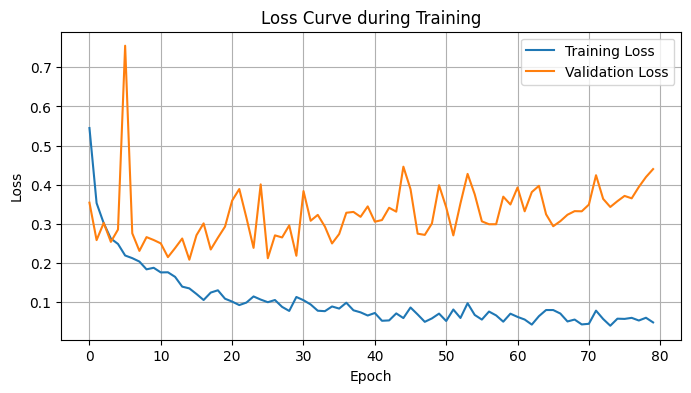

In [55]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
model_name = "best_loss_model.pth"

# model = MLP(input_size=input_shape[1]).to(device)
# model = MLP(input_size=input_shape[1]*input_shape[2]).to(device)
model = CNN_MLP(input_channels=input_shape[1], input_time=input_shape[2]).to(device)
with torch.no_grad():
    dummy = torch.zeros(32, 23, 1280).float().to(device)
    _ = model(dummy)
model.load_state_dict(torch.load(model_name))
y_true, y_prob, y_pred = [], [], []
model.eval()
if model_name == "best_loss_model.pth":
  threshold = config["eval"]["threshold_bestloss"]
elif model_name == "best_model.pth":
  threshold = config["eval"]["threshold_best"]
elif model_name == "last_model.pth":
  threshold = config["eval"]["threshold_last"]
print(f'best threshold: {threshold}')

with torch.no_grad():
    for X, y in tqdm(test_loader):
        X = X.float().to(device)
        y = y.float().to(device)

        logits = model(X).view(-1)
        # for metrics
        y_true.extend(y.cpu().numpy())
        probs = torch.sigmoid(logits)
        preds = (probs >= threshold).long()
        # print(probs)
        y_pred.extend(preds.cpu().numpy().reshape(-1))
        y_prob.extend(probs.cpu().detach().numpy().reshape(-1))
    print('\n')
    test_results = basic_metric(y_true, y_pred, y_prob, metrics=['all'])

best threshold: 0.7999999999999999


100%|██████████| 83/83 [00:00<00:00, 106.92it/s]



accuracy   : 0.9627
recall     : 1.0000
precision  : 0.6475
specificity: 0.9600
AUC        : 0.9977
F1_score   : 0.7860
fpr        : 0.0400


## Tools

### Reload file

In [59]:
import importlib
import dataset

importlib.reload(dataset)

<module 'dataset' from '/Users/kimi/Documents/GitHub/seizure_pred/main/dataset.py'>